In [213]:
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm
import cv2 as cv

In [214]:
DATASET_PATH = "./archive"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annotations")
IMAGES_PATH = path.join(DATASET_PATH, "images")

## Random Sample

Image shape: (256, 400, 4)


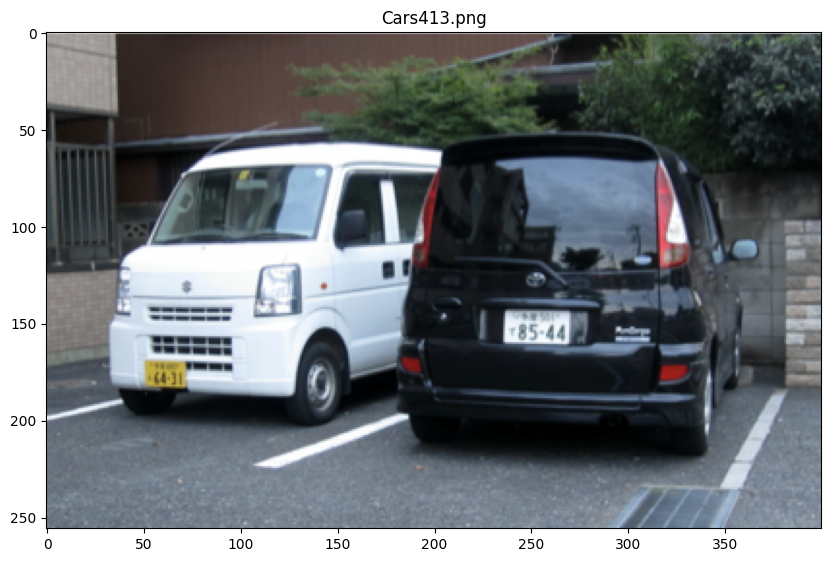

In [215]:
image_filenames = list(walk(IMAGES_PATH))
image_filename = rd.choice(image_filenames[0][2])
image_path = path.join(image_filenames[0][0], image_filename)
img = plt.imread(image_path)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
print('Image shape: {}'.format(img.shape))

In [216]:
annotation = image_filename.split('.')[0] + '.xml'
annotation_path = path.join(ANNOTATIONS_PATH, annotation)
print('Annotation path: {}'.format(annotation_path))

with open(annotation_path, 'r') as f:
    print(f.read())

Annotation path: ./archive/annotations/Cars413.xml

<annotation>
    <folder>images</folder>
    <filename>Cars413.png</filename>
    <size>
        <width>400</width>
        <height>256</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>237</xmin>
            <ymin>143</ymin>
            <xmax>271</xmax>
            <ymax>162</ymax>
        </bndbox>
    </object>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>51</xmin>
            <ymin>170</ymin>
            <xmax>73</xmax>
            <ymax>183</ymax>
        </bndbox>
    </object>
</annotation>


In [217]:
from alprLib.PlateBoundingBox import PlateBoundingBox

plate = PlateBoundingBox(annotation_path)
plate.describe()

PlateBoundingBox
xml_path: ./archive/annotations/Cars413.xml
xmin: 237
ymin: 143
xmax: 271
ymax: 162
width: 34
height: 19
center: (254.0, 152.5)
area: 646



## Draw Bounding Box on image

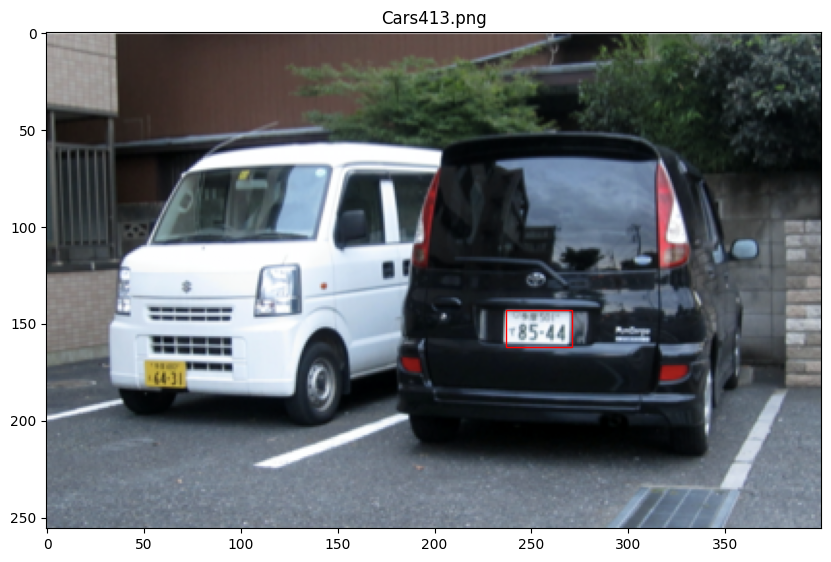

In [218]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
rect = patches.Rectangle((plate.xmin, plate.ymin), plate.width, plate.height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Load Everything in RAM

In [219]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    img = cv.imread(image_path)
    raw_imgs.append(img)

    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    annotations.append(PlateBoundingBox(annotation_path))

  0%|          | 0/433 [00:00<?, ?it/s]

100%|██████████| 433/433 [00:10<00:00, 41.34it/s]


## Gray Scale

In [220]:
grayscale_imgs = []

for image in raw_imgs:
    grayscale_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    blurred_img = cv.GaussianBlur(grayscale_img, ksize=(3, 3), sigmaX=0)  # gaussian blur 

    thresh_img = cv.adaptiveThreshold(
        blurred_img, 
        maxValue=255.0, 
        adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv.THRESH_BINARY_INV, 
        blockSize=19, 
        C=9
    )

    grayscale_imgs.append(thresh_img)

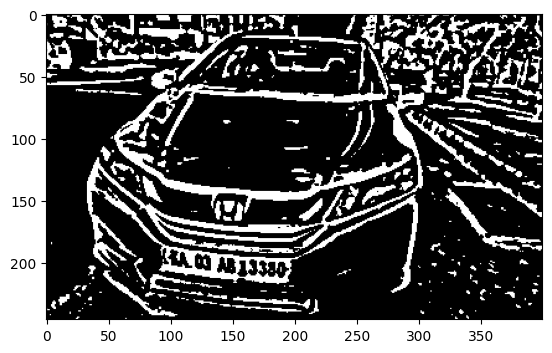

In [221]:
plt.imshow(rd.choice(grayscale_imgs), cmap='gray')
#plt.imshow(grayscale_images[0], cmap='gray')

## Bounding Box extraction

In [222]:
plates = []

for i in range(len(grayscale_imgs)):
    img = grayscale_imgs[i]
    plate = annotations[i]
    xmin = plate.xmin
    ymin = plate.ymin
    xmax = plate.xmax
    ymax = plate.ymax
    plates.append(img[ymin:ymax, xmin:xmax])

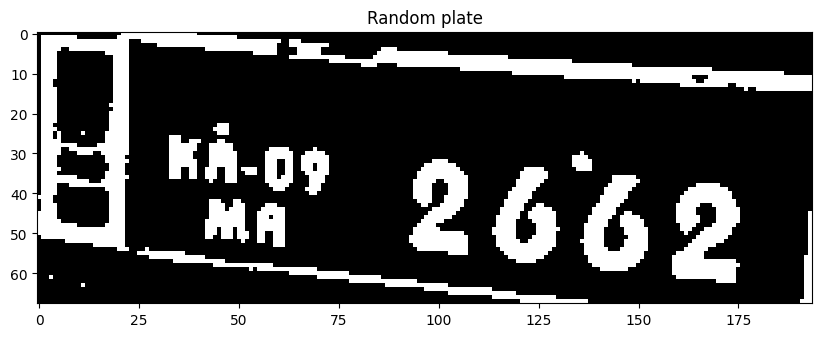

In [232]:
# show a random plate
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Random plate')
ax.imshow(rd.choice(plates), cmap='gray')

## Perspective Correction

In [224]:
# perspective correction of plates
## coutours

## corners

## warp perspective